In [135]:
import subprocess
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [136]:
RUN = 30009

In [137]:
# get stdout from a terminal command
def get_stdout(command):
    return subprocess.check_output(command, shell=True).decode('utf-8')

POD_TO_NODE = {}
def get_node_of_pod(podname):
    if podname in POD_TO_NODE:
        return POD_TO_NODE[podname]
    else:
        node = get_stdout("kubectl get pod " + podname + 
                   " -o jsonpath='{.spec.nodeName}'")
        POD_TO_NODE[podname] = node
        return node

In [138]:
logfilename = f"none_CPU_{RUN}"

with open(logfilename) as f:
    lines = f.readlines()
    
rows = []    
    
for line in lines:
    
    line_json = json.loads(line.strip())
    
    cpu_util = line_json["CPUUtilizations"]
    for podname in cpu_util.keys():
        if podname == "utils":
            continue
        rows.append({
            "time": float(line_json["time"])/10**9,
            "podname": podname,
            "service": "-".join(podname.split("-")[:-1]),
            "node": get_node_of_pod(podname),
            "cpu": float(cpu_util[podname]),
        })
        
df = pd.DataFrame(rows)
df["time"] = df["time"] - df["time"].min()
# df = df[df["time"] <= 30]

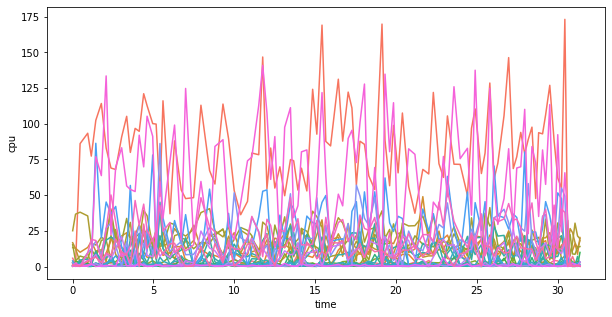

In [139]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

sns.lineplot(ax=ax, data=df, x="time", y="cpu", hue="podname")

#remove legend from ax
ax.get_legend().remove()

In [161]:
# group by podname
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 25)].groupby(["podname", "service", "node"]).mean().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped = df_grouped.sort_values("service", ascending=False)
df_grouped = df_grouped[["podname", "service", "node", "cpu"]].loc[(df_grouped["service"] == "reservation") | (df_grouped["service"] == "rate") | (df_grouped["service"] == "search")]
df_grouped["node"] = df_grouped["node"].apply(lambda x: int(x[-1]) - 1)
df_grouped = df_grouped.sort_values("node", ascending=True)
df_grouped

,podname,service,node,cpu
23,search-0,search,1,24.007165
22,reservation-1,reservation,1,65.651259
21,reservation-0,reservation,2,0.845085
18,rate-0,rate,2,21.447322
19,rate-1,rate,3,0.825469


In [141]:
# group by podname
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 25)].groupby(["node", "podname"]).mean()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

time        cpu
node         podname                                       
minikube     frontend-0                14.564698  83.400737
minikube-m02 reservation-1             14.564698  65.651259
minikube-m04 profile-0                 14.564698  28.236271
minikube-m02 search-0                  14.564698  24.007165
minikube-m03 rate-0                    14.564698  21.447322
             hostagent-node2           14.564698  21.197757
minikube-m04 hostagent-node3           14.564698  18.488011
minikube     hostagent-node0           14.564698  17.954630
minikube-m02 hostagent-node1           14.564698  13.300823
minikube-m03 mongodb-profile-0         14.564698  12.291784
minikube-m02 user-0                    14.564698  10.781507
minikube-m04 recommendation-0          14.564698  10.178364
minikube-m03 geo-0                     14.564698   9.738816
             mongodb-rate-0            14.564698   8.690056
             jaeger-0                  14.564698   3.077787
             consul-0                  14.564698   2.632056
minikube     mongodb-recommendation-0  14.564698   2.246511
minikube-m04 mongodb-reservation-0     14.564698   1.610236
             mongodb-geo-0             14.564698   1.576855
minikube-m03 mongodb-user-0            14.564698   1.352263
minikube     memcached-reserve-0       14.564698   1.241605
minikube-m03 reservation-0             14.564698   0.845085
minikube-m04 rate-1                    14.564698   0.825469
minikube-m02 memcached-rate-0          14.564698   0.614377
             memcached-profile-0       14.564698   0.566224

In [178]:
# group by podname
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 28)].groupby(["podname", "node"]).mean().reset_index().groupby("node").sum().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped = df_grouped.loc[df_grouped["node"] != "minikube"]
df_grouped["node"] = df_grouped["node"].apply(lambda x: int(x[-1]) - 1)
df_grouped[["node", "cpu"]]

,node,cpu
1,1,114.971869
2,2,81.034286
3,3,60.770684


In [179]:
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 28)].groupby(["node", "time"]).sum().reset_index().groupby("node").quantile(0.75).reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped = df_grouped.loc[df_grouped["node"] != "minikube"]
df_grouped["node"] = df_grouped["node"].apply(lambda x: int(x[-1]) - 1)
df_grouped[["node", "cpu"]]

,node,cpu
1,1,143.504191
2,2,95.376639
3,3,73.882581


In [144]:
# group by podname
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 28)].groupby(["podname", "service"]).mean().reset_index().groupby("service").sum().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

,service,time,cpu
1,frontend,16.384335,84.057582
3,hostagent,65.537341,69.262492
17,reservation,32.768670,66.059789
14,profile,16.384335,28.474246
18,search,16.384335,24.568341
15,rate,32.768670,22.557263
9,mongodb-profile,16.384335,12.043121
19,user,16.384335,10.914075
16,recommendation,16.384335,10.427666
2,geo,16.384335,10.018605


In [145]:
df_grouped = df[df["time"] < 1].groupby("podname").mean().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

,podname,time,cpu
1,frontend-0,0.390941,44.990553
5,hostagent-node2,0.390941,33.819416
3,hostagent-node0,0.390941,12.370848
4,hostagent-node1,0.390941,10.343534
6,hostagent-node3,0.390941,8.064921
18,rate-0,0.390941,3.158793
0,consul-0,0.390941,3.061395
13,mongodb-rate-0,0.390941,2.852611
23,search-0,0.390941,2.761592
16,mongodb-user-0,0.390941,1.846166
